In [ ]:
# Sam Maurer, June 2015

In [41]:
%load_ext autoreload
%autoreload 2
import models
import urbansim.sim.simulation as sim
from urbansim.utils import misc

import numpy as np
import pandas as pd
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Figure out how the hedonics are currently estimated

In [2]:
s = sim.get_injectable('store')
s

<class 'pandas.io.pytables.HDFStore'>
File path: ./data/bayarea_v3.h5
/apartments                    frame        (shape->[4327,6])    
/buildings                     frame        (shape->[1841288,18])
/costar                        frame        (shape->[71520,23])  
/homesales                     frame        (shape->[220037,14]) 
/households                    frame        (shape->[2732722,47])
/jobs                          frame        (shape->[3386491,3]) 
/nets                          frame        (shape->[633973,7])  
/parcels                       frame        (shape->[1951911,15])
/zones                         frame        (shape->[1454,4])    
/zoning                        frame        (shape->[42311,19])  
/zoning_for_parcels            frame        (shape->[1951911,1]) 

In [ ]:
# Where does the data for hedonic estimation come from?
# In rsh.yaml, the model expression is: 
'''
np.log(price_per_sqft) ~ I(year_built < 1940) + I(year_built > 2000)
    + np.log1p(sqft_per_unit) + ave_income + stories + poor + renters + sfdu + autoPeakTotal
    + transitPeakTotal + autoOffPeakRetail + ave_lot_size_per_unit + sum_nonresidential_units
    + sum_residential_units
'''

In [27]:
s.costar.columns.values

array(['X', 'Y', 'PropertyType', 'Res', 'City', 'county',
       'averageweightedrent', 'rentable_building_area', 'building_class',
       'parking_ratio', 'percent_leased', 'number_of_stories',
       'year_built', 'zoning', 'fname', 'same', 'two', 'ok', 'parcel_id',
       '_node_id0', '_node_id1', '_node_id2', '_node_id'], dtype=object)

In [5]:
s.homesales.columns.values

array(['X', 'Y', 'City', 'Lot_size', 'SQft', 'Year_built', 'Sale_price',
       'parcel_id', 'sales', 'Sale_price_flt', '_node_id0', '_node_id1',
       '_node_id2', '_node_id'], dtype=object)

In [6]:
s.parcels.columns.values

array(['development_type_id', 'land_value', 'acres', 'county_id',
       'zone_id', 'zoning_id', 'proportion_undevelopable',
       'tax_exempt_status', 'apn', 'parcel_id_local', 'geom_id',
       'imputation_flag', 'x', 'y', 'shape_area'], dtype=object)

In [7]:
s.buildings.columns.values

array(['parcel_id', 'development_type_id', 'improvement_value',
       'residential_units', 'residential_sqft', 'sqft_per_unit',
       'non_residential_sqft', 'building_sqft', 'nonres_rent_per_sqft',
       'res_price_per_sqft', 'stories', 'year_built', 'redfin_sale_price',
       'redfin_sale_year', 'redfin_home_type', 'costar_property_type',
       'costar_rent', 'building_type_id'], dtype=object)

In [ ]:
# Many of the inputs come from the neighborhood_vars model, which does network aggregation
# and stores its results in the 'nodes' table -- and others are defined in variables.py
'''
price_per_sqft:              homesales (which does not come from the h5 table, but is 
                                 constructed on the fly from the buildings table)
                                 buildings > redfin_sale_price and sqft_per_unit
                                 
year_built:                  buildings
sqft_per_unit:               buildings dynamic column
ave_income:                  nodes, from households > income
stories:                     buildings
poor:                        nodes, from households > persons
renters:                     nodes, from households > tenure
sfdu:                        nodes, from buildings > building_type_id
autoPeakTotal:               logsums
transitPeakTotal:            logsums
autoOffPeakRetail:           logsums
ave_lot_size_per_unit:       nodes, from buildings dynamic column
sum_nonresidential_units:    nodes, from buildings dynamic column
sum_residential_units:       nodes, from buildings > residential_units
'''

In [ ]:
# Note for future -- best way to look at the data urbansim is actually using is to call 
# sim.get_table(), because the h5 file is only a starting point for the data structures

### 2. Bring in Craigslist data as a separate table, and link to node geography

In [ ]:
# Craigslist gives us x,y coordinates, but they're not accurate enough to link
# to a specific parcel. Probably the best approach is to set up a new table for CL
# data, and then use a broadcast to link them to the nodes and logsums tables

In [15]:
# This data is from Geoff Boeing, representing 2.5 months of listings for the SF Bay Area
# Craigslist region. He's already done some moderate cleaning, filtering for plausible
# lat/lon and square footage values and removing posts that were duplicated using CL's
# 'repost' tool. Other duplicate listings still remain.

df = pd.read_csv(os.path.join(misc.data_dir(), "sfbay_craigslist.csv"))

In [16]:
df.describe()

,price,bedrooms,sqft,longitude,latitude,price_sqft
count,73644.000000,68812.000000,73644.00000,73644.000000,73644.000000,73644.000000
mean,3806.642944,1.918575,1196.62111,-122.108903,37.639416,4.697802
std,146802.055710,0.935159,31192.63512,1.359750,0.863417,183.768413
min,1.000000,1.000000,1.00000,-159.609375,-85.561269,0.000154
25%,1831.000000,1.000000,720.00000,-122.286807,37.383128,2.055256
50%,2330.500000,2.000000,904.00000,-122.050473,37.601374,2.587519
75%,2986.000000,2.000000,1160.00000,-121.952270,37.844037,3.135714
max,26722744.000000,8.000000,8388607.00000,146.425781,79.858833,31145.389277


In [17]:
# Borrowing code from datasources.py to link x,y coods to nodes
net = sim.get_injectable('net')
df['_node_id'] = net.get_node_ids(df['longitude'], df['latitude'])

In [19]:
df['_node_id'].describe()

count     73644.000000
mean     156857.443906
std      100783.186320
min          62.000000
25%       80038.000000
50%      149462.000000
75%      190924.000000
max      354659.000000
Name: _node_id, dtype: float64

In [25]:
df.head(5)

,neighborhood,price,bedrooms,date,sqft,longitude,latitude,price_sqft,_node_id
0,twin peaks / diamond hts,4500,2,2014-05-11,1200,-122.438300,37.745000,3.750000,300155
1,sunnyvale,2650,2,2014-05-11,1040,-122.008131,37.353699,2.548077,143129
2,glen park,3100,2,2014-05-11,1000,-122.439743,37.731584,3.100000,125905
3,redwood city,1850,1,2014-05-11,792,-122.234294,37.491715,2.335859,143879
4,walnut creek,1325,1,2014-05-11,642,-122.087751,37.923448,2.063863,70923


### 3. Clean up the data

In [ ]:
# - Need to deal with NA's
# - Should also choose some outlier thresholds

In [30]:
df.isnull().sum()

neighborhood     294
price              0
bedrooms        4832
date               0
sqft               0
longitude          0
latitude           0
price_sqft         0
_node_id           0
dtype: int64

In [33]:
df['bedrooms'] = df.bedrooms.replace(np.nan, 1)
df['neighborhood'] = df.neighborhood.replace(np.nan, '')

In [34]:
df.isnull().sum()

neighborhood    0
price           0
bedrooms        0
date            0
sqft            0
longitude       0
latitude        0
price_sqft      0
_node_id        0
dtype: int64

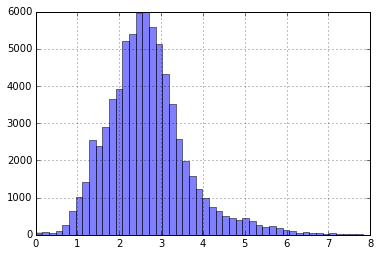

In [50]:
df.price_sqft[df.price_sqft<8].hist(bins=50, alpha=0.5)

In [ ]:
# try 0.5 and 7 as thresholds to get rid of worst outliers